In [1]:
import gym
import tensorflow as tf
import numpy as np

In [2]:
env = gym.make('MountainCarContinuous-v0')
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)
n_actions = env.action_space.shape[0]
n_states = env.observation_space.shape[0]
print(n_actions)
print(n_states)

[2017-11-10 10:07:04,613] Making new env: MountainCarContinuous-v0


[ 0.6   0.07]
[-1.2  -0.07]
[ 1.]
[-1.]
1
2


In [3]:
n_hidden = 32
learning_rate = 0.01
gamma = 0.99
episodes = 500
t_max = 20000
np.random.seed(10)
tf.set_random_seed(10)

In [4]:
states = tf.placeholder(tf.float32, shape=[None, n_states], name='states')
actions = tf.placeholder(tf.float32, name='actions')
rewards = tf.placeholder(tf.float32, name='rewards')

In [5]:
w_hid1 = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[n_states, n_hidden]), name='whid1')
w_bias1 = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[n_hidden]), name='wbias1')
out1 = tf.add(tf.matmul(states, w_hid1),w_bias1)
w_hid2 = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[n_hidden, n_actions]), name='whid2')
w_bias2 = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[n_actions]), name='wbias2')
out = tf.add(tf.matmul(out1, w_hid2), w_bias2)

logits = tf.nn.tanh(out)

In [6]:
loss = -1 * tf.reduce_mean(tf.log(logits) * rewards)

update = tf.train.AdamOptimizer(learning_rate).minimize(loss) 

In [7]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    discounted_ep_rs = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(0, len(rewards))):
        running_add = running_add * gamma + rewards[t]
        discounted_ep_rs[t] = running_add

        # normalize episode rewards
    discounted_ep_rs -= np.mean(discounted_ep_rs)
    discounted_ep_rs /= np.std(discounted_ep_rs)
    return discounted_ep_rs
    
test_rew = [1.0, 2.0, 3.0, 4.0, 5.0, -1.0] 
print(get_cumulative_rewards(test_rew, 0.1))

[-0.6612174  -0.11133761  0.43541745  0.95092512  1.15395888 -1.76774644]


In [8]:
'''def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    final = []
    for i in range(len(rewards)):
        temp = rewards[i]
        for j in range(i+1, len(rewards)):
            temp = temp + rewards[j] * (gamma ** (j - i))
        final.append(temp)
    final -= np.mean(final)
    final /= np.std(final)
    return final
    
test_rew = [1.0, 2.0, 3.0] 
print(get_cumulative_rewards(test_rew, 0.1))'''

'def get_cumulative_rewards(rewards, #rewards at each step\n                           gamma = 0.99 #discount for reward\n                           ):\n    """\n    take a list of immediate rewards r(s,a) for the whole session \n    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton \'16)\n    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...\n    \n    The simple way to compute cumulative rewards is to iterate from last to first time tick\n    and compute R_t = r_t + gamma*R_{t+1} recurrently\n    \n    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.\n    """\n    final = []\n    for i in range(len(rewards)):\n        temp = rewards[i]\n        for j in range(i+1, len(rewards)):\n            temp = temp + rewards[j] * (gamma ** (j - i))\n        final.append(temp)\n    final -= np.mean(final)\n    final /= np.std(final)\n    return final\n    \ntest_rew = [1.0, 2.0, 3.0] \nprint(get_cumulative_rewards(test_rew, 0.1))'

In [9]:
def choose_action(state):
    action = logits.eval(feed_dict={states: state})[0]
    return action

In [10]:
sess = tf.InteractiveSession()
# tf.initialize_all_variables()
sess.run(tf.global_variables_initializer())

reward_list = []

for i in range(episodes):
    s = env.reset()
    s_, a_, r_ = [], [], []
    for t in range(t_max):
        s = np.reshape(s, (-1, n_states))
        a = choose_action(s)
        new_s, r, done, _ = env.step(a)
        s_.append(s)
        a_.append(a)
        r_.append(r)
        s = new_s
        if done:
            r_cumu = get_cumulative_rewards(r_)
            s_new = np.reshape(s_, (-1, n_states))
            update.run({states:s_new, actions:a_, rewards:r_cumu})
            print('episode:{0} reward:{1}'.format(i, sum(r_)))
            reward_list.append(sum(r_))
            break

episode:0 reward:74.66741919493637
episode:1 reward:74.33548794706248
episode:2 reward:63.366757338416406
episode:3 reward:-38.41659870840771
episode:4 reward:-39.95926787164921
episode:5 reward:-39.72713786324581
episode:6 reward:-37.264938120262144
episode:7 reward:78.11499773663166
episode:8 reward:-35.7804954871683
episode:9 reward:74.05539247197869
episode:10 reward:-34.71428449998103
episode:11 reward:65.03358485500995
episode:12 reward:66.89283595057046
episode:13 reward:-35.80036253935117
episode:14 reward:-37.11977329983277
episode:15 reward:73.30610569890136
episode:16 reward:-36.91080176786266
episode:17 reward:70.23056590936254
episode:18 reward:-38.32675839248977
episode:19 reward:77.44288088735766
episode:20 reward:66.81974402257896
episode:21 reward:78.02117485728448
episode:22 reward:70.28207300412868
episode:23 reward:64.30829411815434
episode:24 reward:77.63885151355586
episode:25 reward:72.45766664316588
episode:26 reward:62.24557089846234
episode:27 reward:-38.51347

KeyboardInterrupt: 

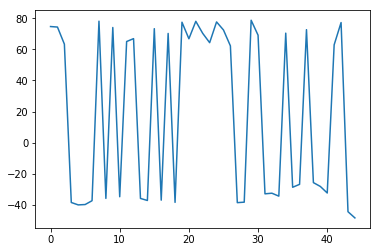

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(reward_list)
plt.show()

In [16]:
s = env.reset()
r_test = 0
for t in range(t_max):
    env.render()
    s = np.reshape(s, (-1, n_states))
    a = choose_action(s)
    new_s, r, done, _ = env.step(a)
    s = new_s
    r_test = r + r_test
    if done:
        break
print(r_test)

70.01713726495353
